In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install dropbox
!pip install librosa
!pip install rarfile

In [2]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display
import random
import json
import os
from math import floor, ceil

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
    
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
import rarfile

with rarfile.RarFile("/content/drive/MyDrive/Datasets/speech_emotion_data_rav_JL.rar", "r") as zip_ref:
  zip_ref.extractall("speech_emotion_data_rav_JL")

In [7]:
data = []
with open("speech_emotion_data_rav_JL/speech_emotion_data_rav_JL.json", "r") as f:
    data = json.load(f)

In [8]:
random.seed(0)

random.shuffle(data)

In [9]:
X_all, Y_all = [], []

for item in data:
    X_all.append(item["feature"])
    Y_all.append(item["label"])

In [10]:
print(len(X_all), len(Y_all))
print(len(X_all[1]), len(Y_all[0]))

2064 2064
1690 5


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(X_all, dtype="float32").reshape((-1, 13, 130, 1)), 
    np.array(Y_all, dtype="float32").reshape((-1, 5)), 
    test_size=0.30,
    random_state=42,
    shuffle=True)

In [12]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1444, 13, 130, 1) (1444, 5)
(620, 13, 130, 1) (620, 5)


In [13]:
def CreateModel():
    model = tf.keras.Sequential()
    dropout_prob = 0.4
    
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=7, activation="tanh", padding="same", input_shape=(13, 130, 1)))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Dropout(dropout_prob))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation="tanh", padding="same"))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Dropout(dropout_prob))
    

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="tanh", padding="same"))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Dropout(dropout_prob))

    model.add(tf.keras.layers.Flatten())

    # model.add(tf.keras.layers.Dense(units=50, activation="sigmoid"))
    
    model.add(tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer"))
    
    return model

In [14]:

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoint_speech_lj_rav",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


with tf.device("/gpu:0"):
    Model = CreateModel()

    Model.compile(
        loss="bce",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
  
    # Model.summary()

    history = Model.fit(x=X_train,
                        y=Y_train,
                        epochs=500,
                        batch_size=512,
                        validation_data=(X_test, Y_test),
                        shuffle=True,
                        callbacks=[model_checkpoint])

Epoch 1/500
3/3 [==============================] - 5s 650ms/step - loss: 0.6333 - accuracy: 0.2066 - val_loss: 0.6056 - val_accuracy: 0.1935
INFO:tensorflow:Assets written to: model_checkpoint_speech_lj_rav/assets
Epoch 2/500
3/3 [==============================] - 0s 114ms/step - loss: 0.5394 - accuracy: 0.1832 - val_loss: 0.5045 - val_accuracy: 0.2161
INFO:tensorflow:Assets written to: model_checkpoint_speech_lj_rav/assets
Epoch 3/500
3/3 [==============================] - 0s 206ms/step - loss: 0.5141 - accuracy: 0.2280 - val_loss: 0.4936 - val_accuracy: 0.2694
INFO:tensorflow:Assets written to: model_checkpoint_speech_lj_rav/assets
Epoch 4/500
3/3 [==============================] - 0s 117ms/step - loss: 0.5115 - accuracy: 0.2294 - val_loss: 0.4927 - val_accuracy: 0.2984
INFO:tensorflow:Assets written to: model_checkpoint_speech_lj_rav/assets
Epoch 5/500
3/3 [==============================] - 0s 118ms/step - loss: 0.5040 - accuracy: 0.2487 - val_loss: 0.4891 - val_accuracy: 0.3161
INF

In [15]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 13, 130, 1)        4         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 130, 128)      6400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 65, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 65, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 65, 64)         204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 32, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 32, 64)         0

In [16]:
Model = tf.keras.models.load_model("model_checkpoint_speech_lj_rav")

In [17]:
Model.evaluate(X_test, Y_test)
Model.evaluate(np.array(X_all, dtype="float32").reshape((-1, 13, 130, 1)), 
               np.array(Y_all, dtype="float32").reshape((-1, 5)))

65/65 [==============================] - 0s 4ms/step - loss: 0.0552 - accuracy: 0.9680


[0.05518127977848053, 0.9680232405662537]

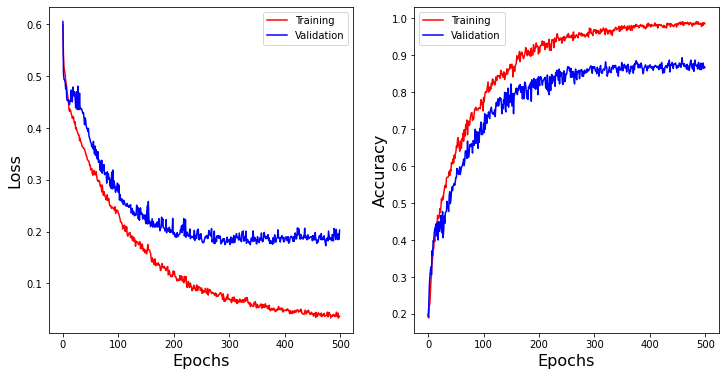

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

1/1 [==============================] - 0s 173ms/step - loss: 0.3104 - accuracy: 1.0000
[[4.8924442e-09 8.3037156e-01 1.6961998e-01 1.2563920e-06 7.1591194e-06]]


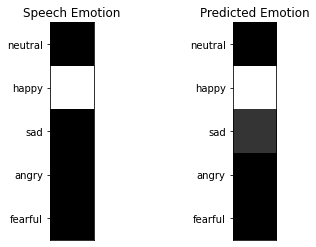

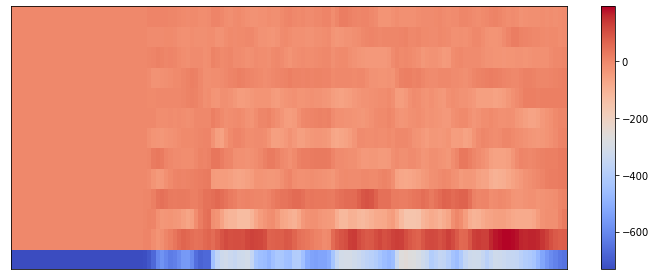

1/1 [==============================] - 0s 14ms/step - loss: 0.0454 - accuracy: 1.0000
[[6.7144341e-04 9.9930978e-01 1.7484354e-08 1.2111589e-08 1.8868341e-05]]


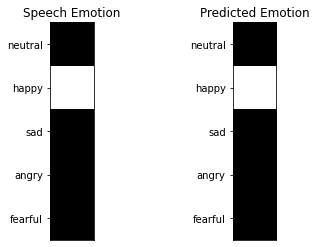

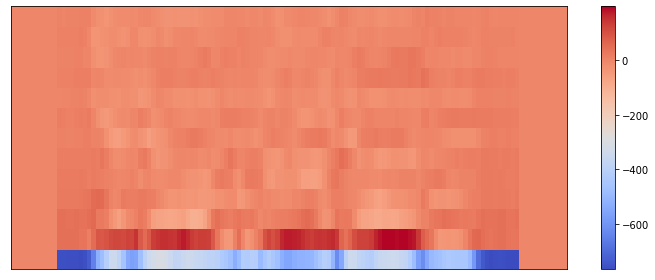

1/1 [==============================] - 0s 15ms/step - loss: 0.6313 - accuracy: 0.0000e+00
[[0.01039467 0.0035994  0.24377598 0.00099315 0.7412368 ]]


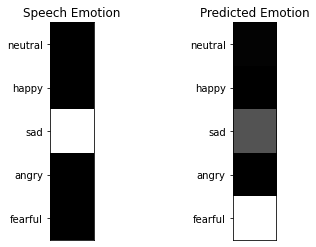

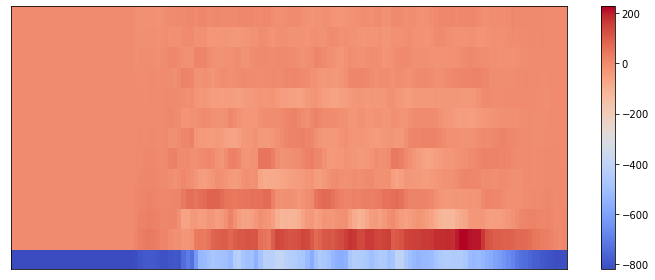

1/1 [==============================] - 0s 16ms/step - loss: 0.1365 - accuracy: 1.0000
[[1.00550584e-01 1.01175516e-04 7.52030406e-04 2.06310347e-07
  8.98596048e-01]]


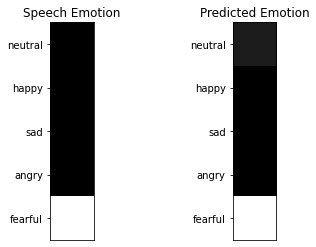

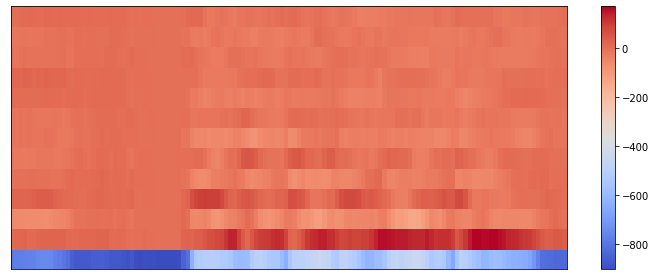

1/1 [==============================] - 0s 17ms/step - loss: 0.2645 - accuracy: 1.0000
[[6.3351107e-01 3.9170838e-05 3.6639777e-01 5.1843566e-05 1.6428724e-07]]


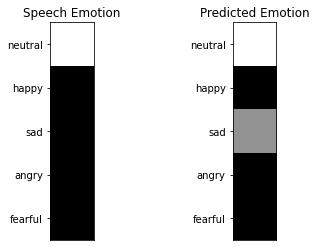

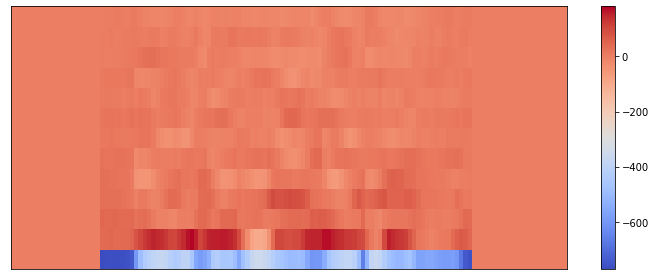

1/1 [==============================] - 0s 16ms/step - loss: 0.1180 - accuracy: 1.0000
[[6.5518591e-08 1.0367918e-02 1.6059467e-06 9.8963028e-01 7.9975663e-08]]


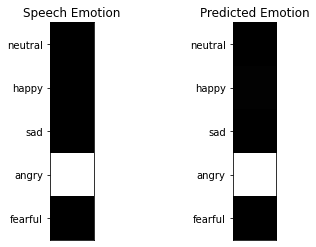

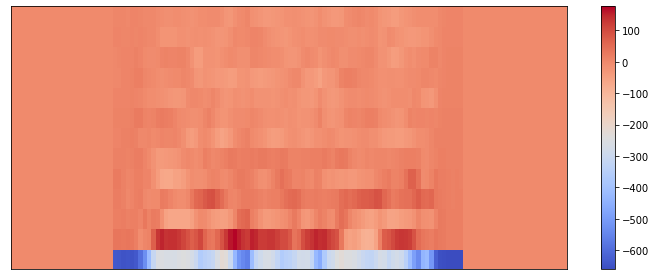

1/1 [==============================] - 0s 15ms/step - loss: 0.0619 - accuracy: 1.0000
[[7.4652750e-03 9.8284435e-01 5.7497101e-07 8.1232291e-05 9.6086347e-03]]


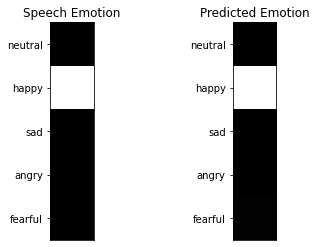

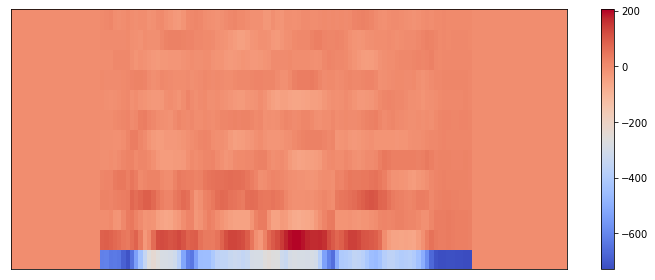

1/1 [==============================] - 0s 14ms/step - loss: 0.1546 - accuracy: 1.0000
[[1.5456857e-07 9.1154486e-01 9.5722612e-08 3.5723492e-06 8.8451393e-02]]


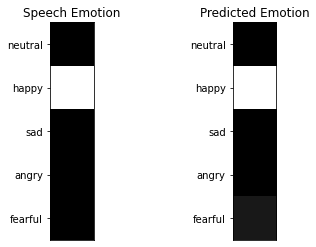

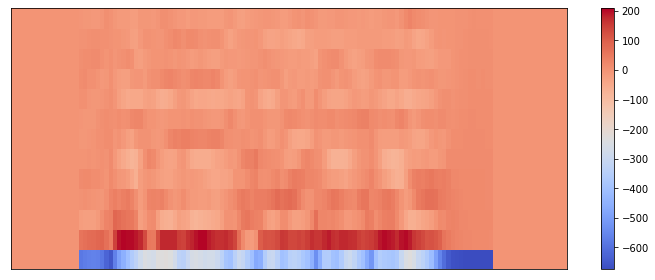

1/1 [==============================] - 0s 15ms/step - loss: 0.0529 - accuracy: 1.0000
[[1.50555552e-05 2.46305372e-05 9.88659859e-01 4.20251687e-04
  1.08800875e-02]]


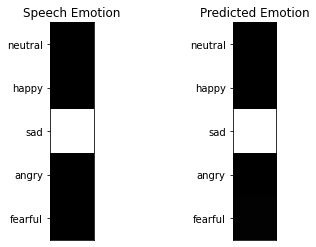

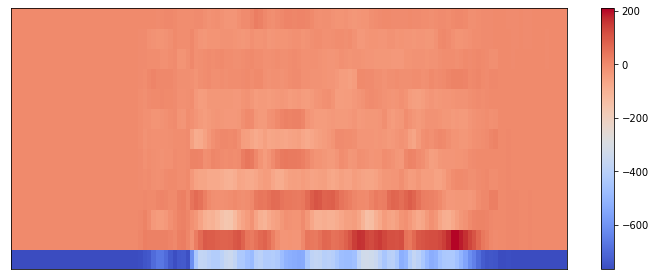

1/1 [==============================] - 0s 14ms/step - loss: 9.9011e-04 - accuracy: 1.0000
[[4.9282388e-08 2.7195730e-07 2.6411181e-08 3.6990300e-06 9.9999595e-01]]


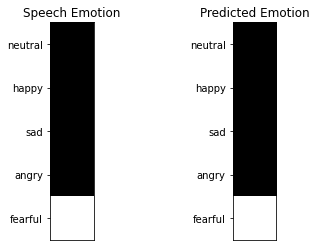

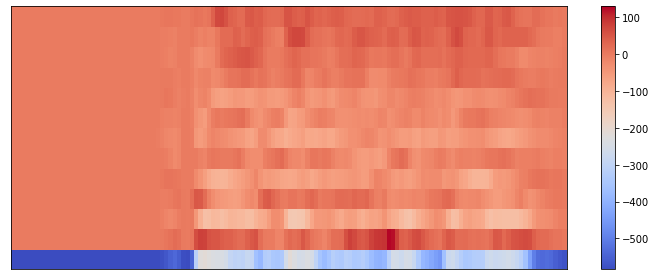

1/1 [==============================] - 0s 15ms/step - loss: 0.0093 - accuracy: 1.0000
[[6.5745931e-05 1.2162677e-05 1.3206994e-09 5.0812815e-10 9.9992204e-01]]


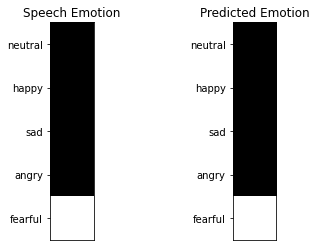

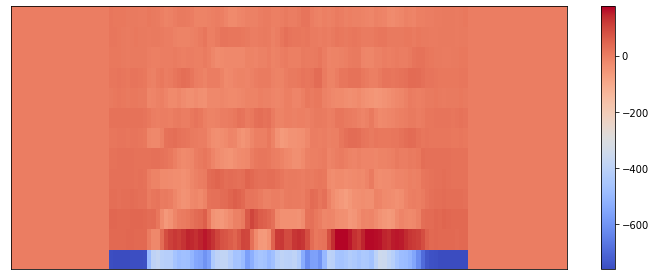

1/1 [==============================] - 0s 15ms/step - loss: 0.0045 - accuracy: 1.0000
[[2.3196767e-06 2.1806762e-05 9.7346492e-05 3.0443445e-07 9.9987817e-01]]


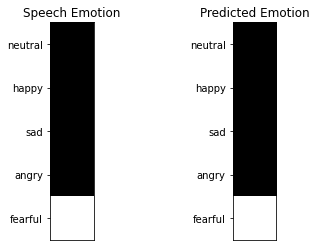

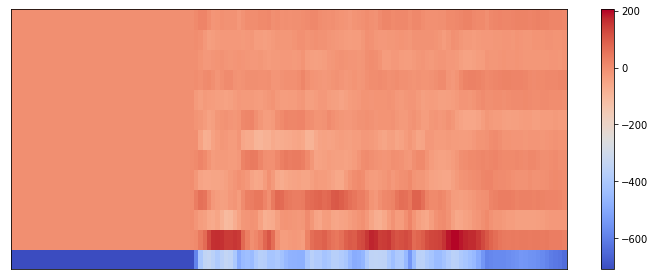

1/1 [==============================] - 0s 17ms/step - loss: 0.0064 - accuracy: 1.0000
[[3.4752331e-05 9.9996316e-01 1.8851234e-06 8.8755303e-10 6.8691165e-08]]


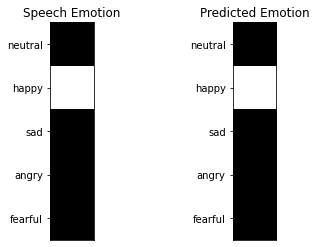

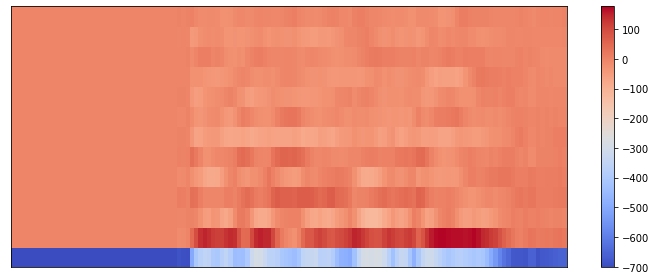

1/1 [==============================] - 0s 16ms/step - loss: 0.1238 - accuracy: 1.0000
[[1.9457048e-03 4.4654662e-08 9.9805427e-01 2.2380785e-08 4.8709808e-08]]


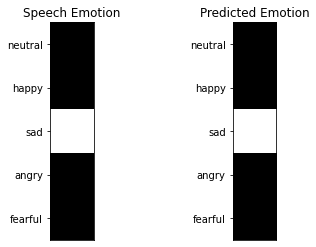

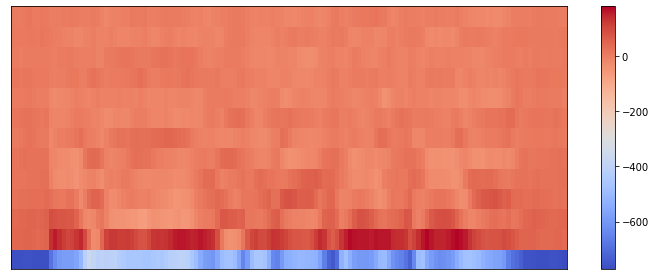

1/1 [==============================] - 0s 15ms/step - loss: 0.0165 - accuracy: 1.0000
[[3.5922141e-05 2.3557033e-07 9.9851519e-01 3.5342531e-05 1.4132692e-03]]


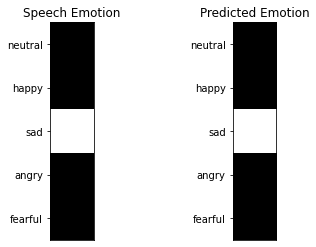

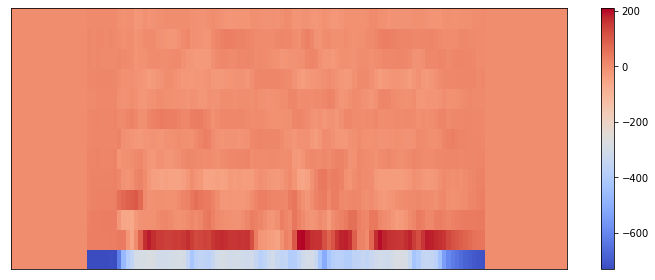

1/1 [==============================] - 0s 16ms/step - loss: 0.0070 - accuracy: 1.0000
[[4.7064070e-05 9.9969304e-01 2.4150489e-04 1.8240346e-05 1.4243643e-07]]


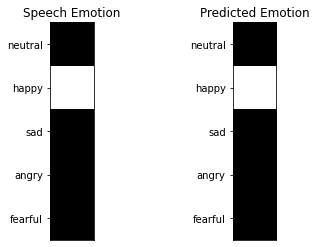

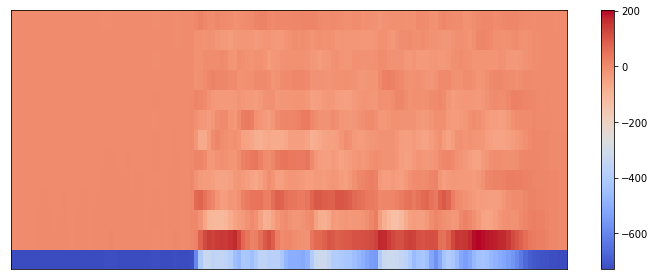

1/1 [==============================] - 0s 15ms/step - loss: 0.0243 - accuracy: 1.0000
[[8.5886668e-06 1.4432212e-03 9.9847597e-01 7.2069866e-05 1.9638833e-07]]


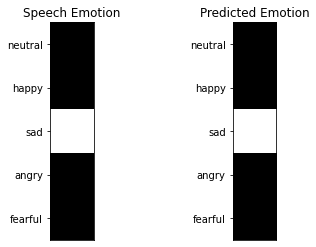

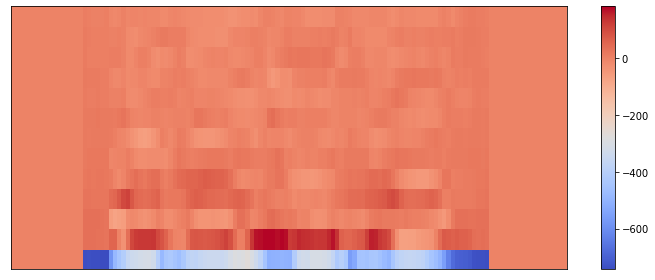

1/1 [==============================] - 0s 17ms/step - loss: 0.0022 - accuracy: 1.0000
[[1.8167698e-10 3.5108508e-06 5.3135061e-08 1.0766736e-10 9.9999642e-01]]


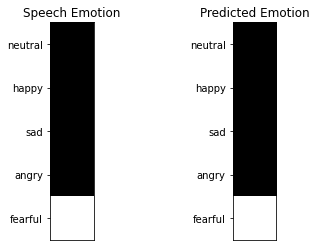

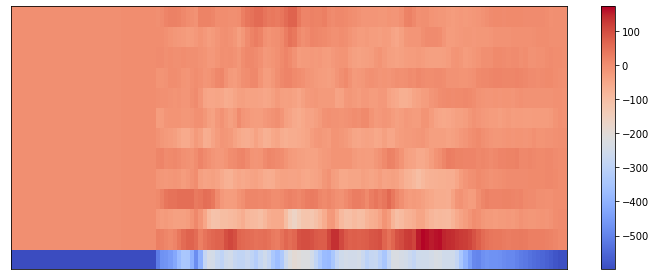

1/1 [==============================] - 0s 15ms/step - loss: 0.6651 - accuracy: 0.0000e+00
[[4.77153779e-04 1.11114465e-01 1.94492873e-06 8.22781920e-01
  6.56244233e-02]]


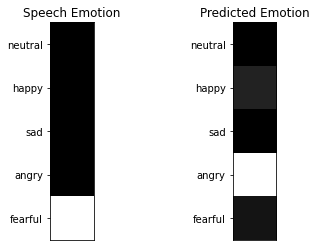

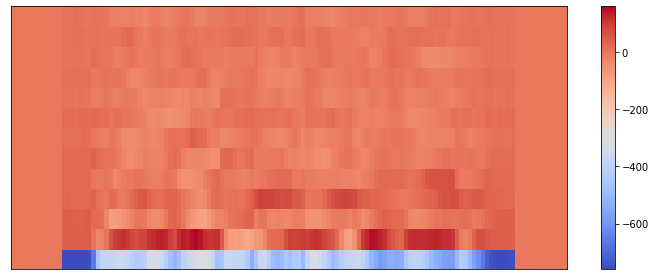

1/1 [==============================] - 0s 14ms/step - loss: 6.7954e-05 - accuracy: 1.0000
[[2.1036617e-14 2.1670194e-13 7.7437059e-12 1.0000000e+00 3.2965609e-13]]


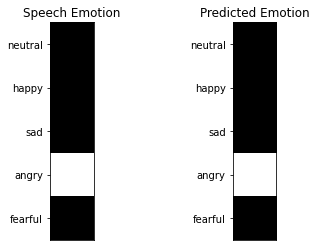

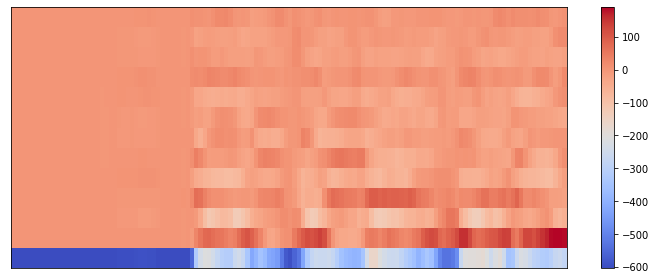

1/1 [==============================] - 0s 17ms/step - loss: 0.1448 - accuracy: 1.0000
[[1.36466315e-02 9.12312031e-01 1.34057563e-03 1.03380160e-06
  7.26997629e-02]]


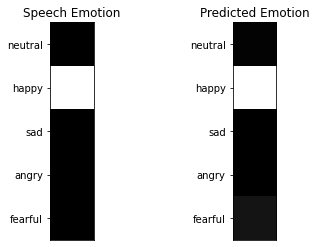

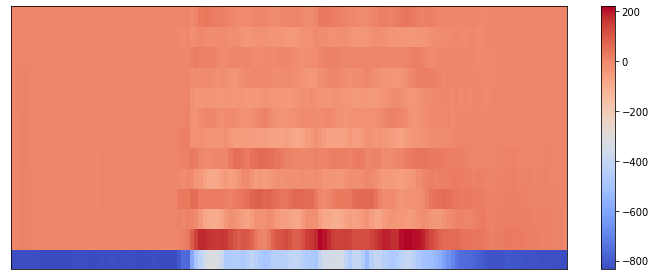

1/1 [==============================] - 0s 15ms/step - loss: 5.1578e-04 - accuracy: 1.0000
[[8.1357171e-11 5.2343370e-09 1.0947475e-09 9.9999988e-01 1.5120835e-07]]


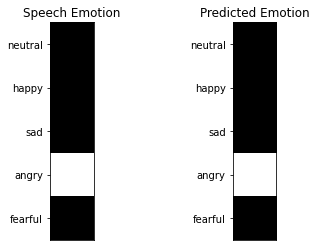

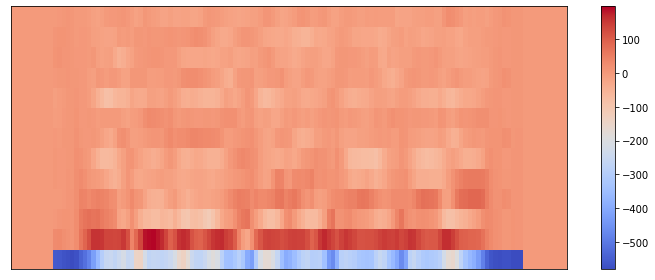

1/1 [==============================] - 0s 15ms/step - loss: 0.0670 - accuracy: 1.0000
[[1.8617369e-05 1.3979968e-07 9.8315086e-03 2.8128348e-08 9.9014974e-01]]


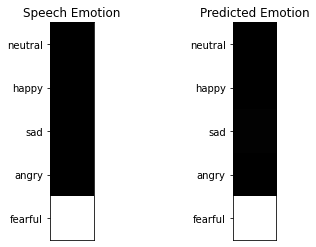

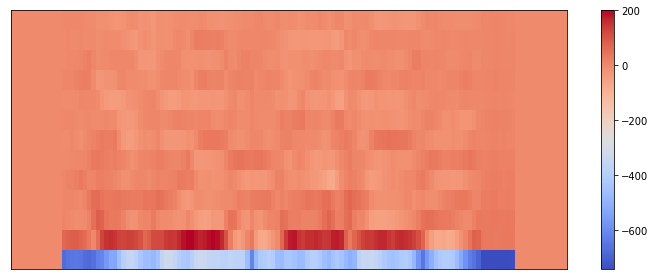

1/1 [==============================] - 0s 20ms/step - loss: 0.2540 - accuracy: 1.0000
[[0.14309315 0.83400846 0.00488316 0.00207654 0.01593862]]


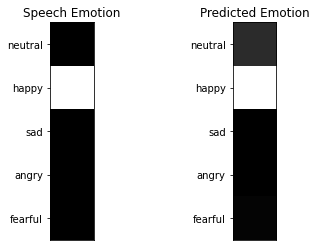

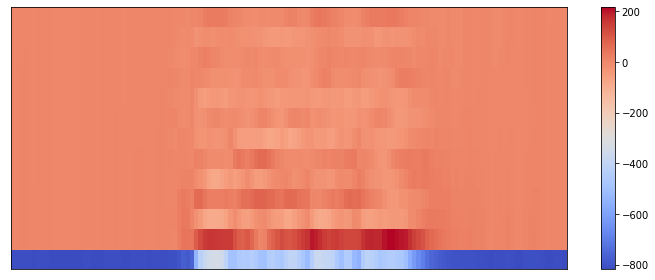

1/1 [==============================] - 0s 17ms/step - loss: 0.5114 - accuracy: 1.0000
[[2.9633602e-08 9.9828809e-01 1.9910480e-11 4.3326540e-11 1.7118319e-03]]


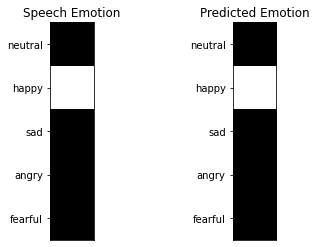

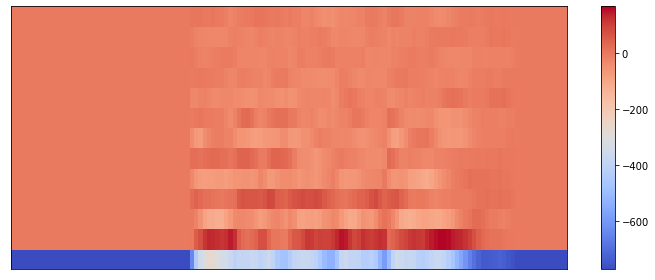

1/1 [==============================] - 0s 17ms/step - loss: 1.8113e-04 - accuracy: 1.0000
[[1.3775123e-13 7.7609391e-10 6.9370752e-11 7.8606242e-09 1.0000000e+00]]


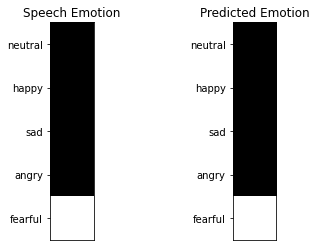

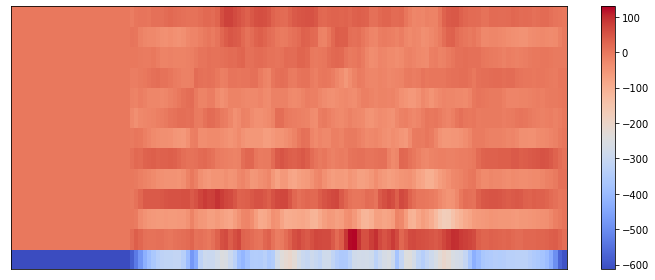

1/1 [==============================] - 0s 16ms/step - loss: 0.0040 - accuracy: 1.0000
[[9.9997878e-01 1.7632489e-10 1.9689132e-05 1.0700262e-09 1.5279543e-06]]


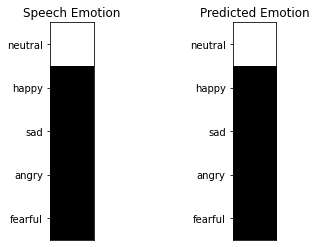

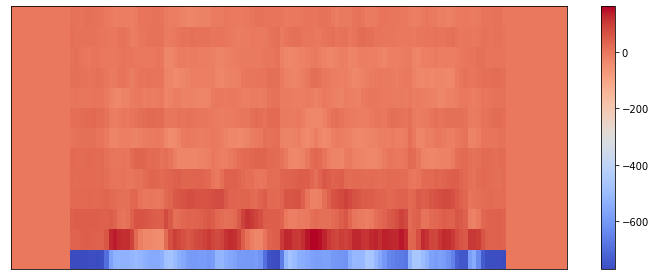

1/1 [==============================] - 0s 16ms/step - loss: 1.1490e-04 - accuracy: 1.0000
[[5.6315845e-09 9.8081361e-12 1.0000000e+00 2.8252604e-12 6.0145013e-09]]


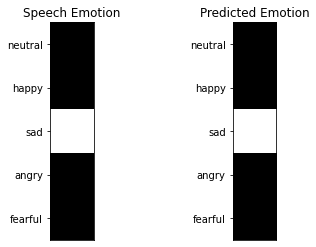

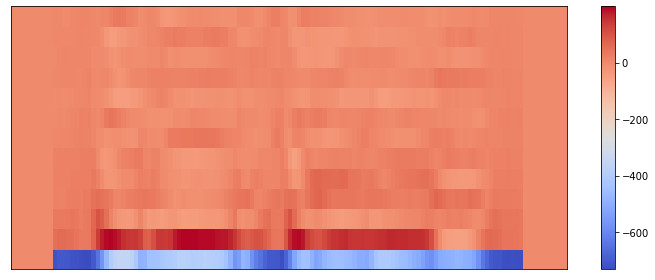

1/1 [==============================] - 0s 15ms/step - loss: 0.0090 - accuracy: 1.0000
[[2.3209639e-05 9.9955696e-01 5.1347575e-09 1.5856430e-04 2.6120283e-04]]


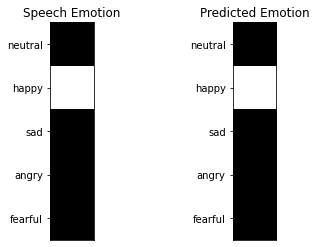

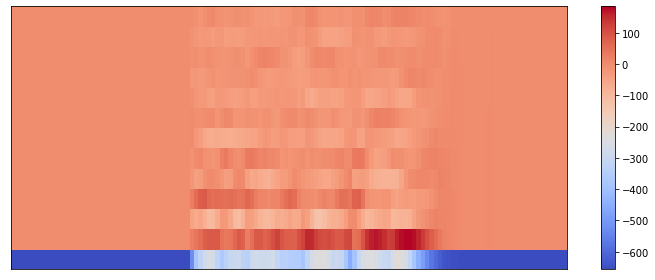

1/1 [==============================] - 0s 15ms/step - loss: 0.1404 - accuracy: 1.0000
[[3.5503988e-06 1.3151601e-05 1.1755820e-01 1.6634649e-05 8.8240844e-01]]


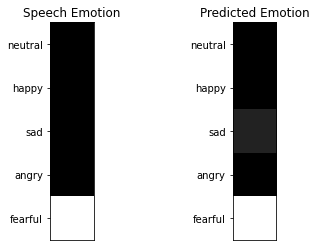

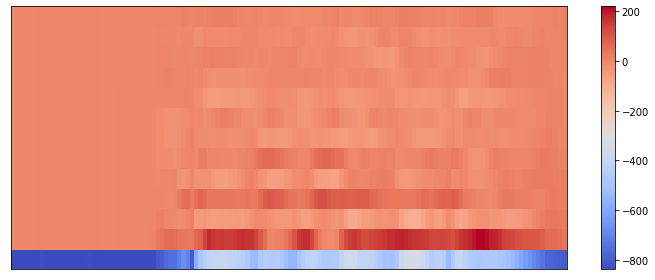

1/1 [==============================] - 0s 16ms/step - loss: 1.3901 - accuracy: 0.0000e+00
[[4.1436979e-05 9.9886996e-01 4.1099185e-05 9.1831835e-06 1.0383874e-03]]


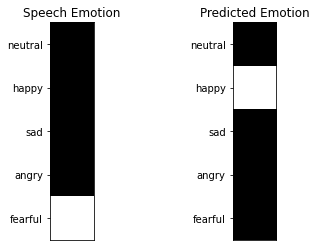

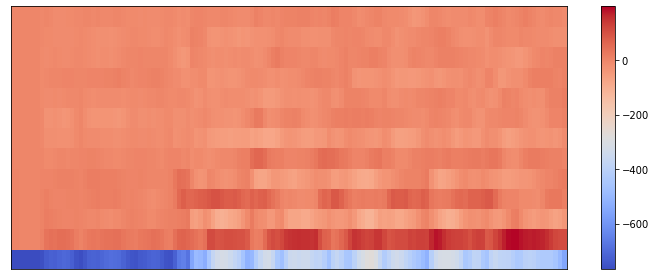

1/1 [==============================] - 0s 15ms/step - loss: 1.4266e-04 - accuracy: 1.0000
[[5.8305083e-10 8.4044744e-09 1.7724194e-08 5.3312313e-11 1.0000000e+00]]


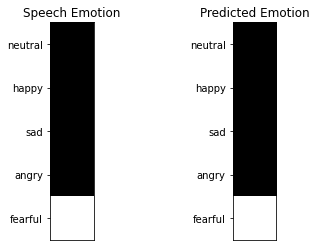

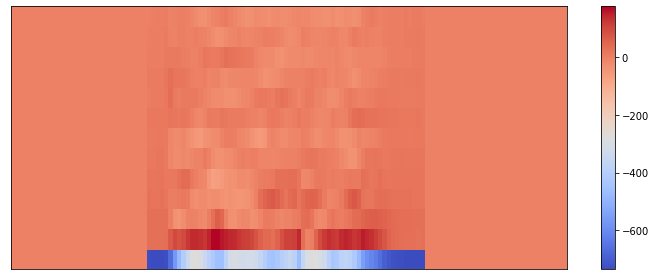

1/1 [==============================] - 0s 17ms/step - loss: 0.0047 - accuracy: 1.0000
[[9.9986553e-01 1.6408677e-07 3.5912217e-05 4.9485433e-08 9.8370321e-05]]


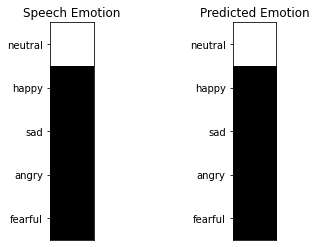

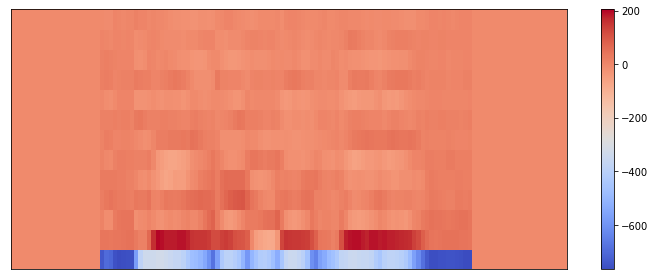

1/1 [==============================] - 0s 15ms/step - loss: 0.0921 - accuracy: 1.0000
[[1.2906546e-07 2.5363141e-04 9.9153817e-01 2.5410231e-03 5.6669540e-03]]


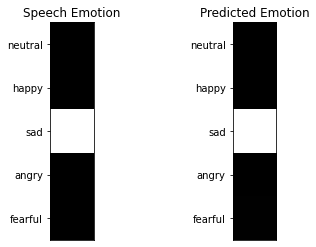

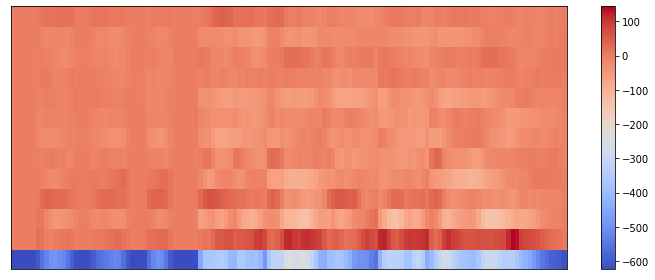

1/1 [==============================] - 0s 16ms/step - loss: 0.0415 - accuracy: 1.0000
[[5.5816551e-10 1.7341753e-11 3.3543815e-06 7.0849788e-13 9.9999666e-01]]


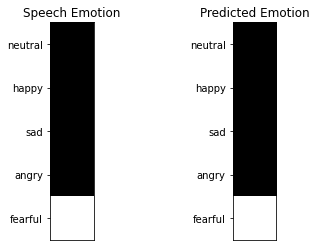

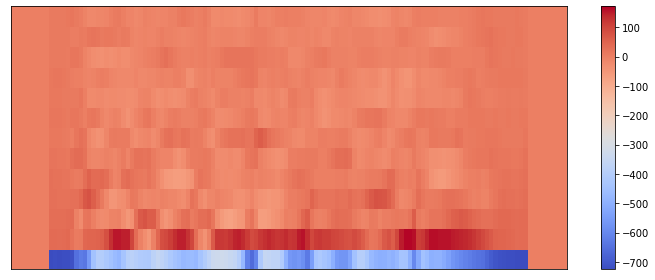

1/1 [==============================] - 0s 19ms/step - loss: 3.1766e-04 - accuracy: 1.0000
[[7.9343705e-09 9.9999964e-01 6.1596070e-09 4.1764508e-08 3.6526885e-07]]


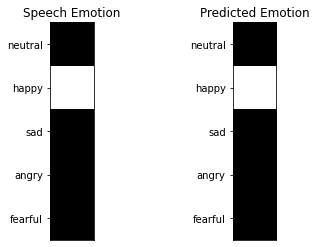

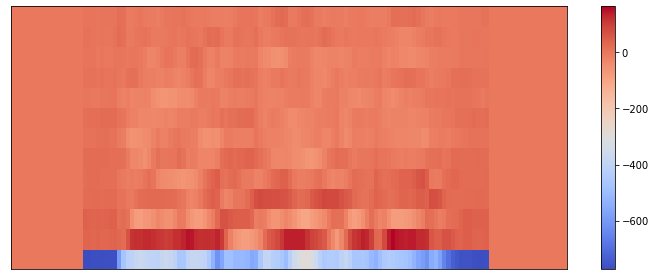

1/1 [==============================] - 0s 19ms/step - loss: 0.4343 - accuracy: 1.0000
[[6.6367948e-06 4.1628492e-01 3.3260760e-04 6.8169320e-13 5.8337587e-01]]


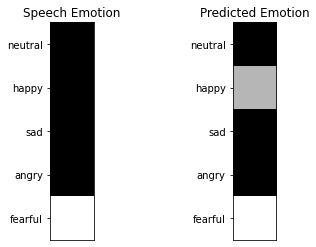

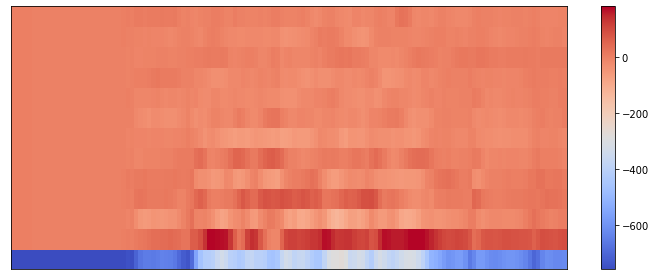

1/1 [==============================] - 0s 14ms/step - loss: 0.0037 - accuracy: 1.0000
[[2.9352215e-08 9.9996090e-01 5.4268316e-08 4.2660772e-06 3.4751916e-05]]


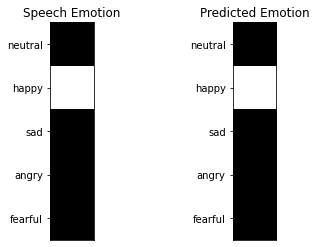

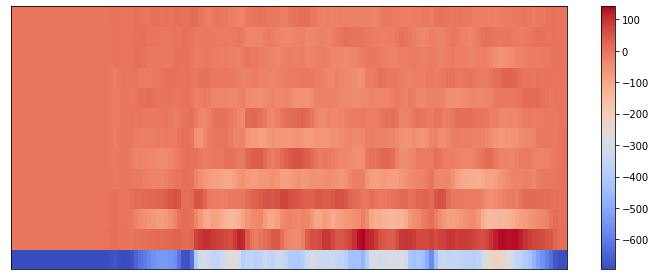

1/1 [==============================] - 0s 16ms/step - loss: 1.0252 - accuracy: 0.0000e+00
[[9.8987108e-01 1.4634780e-03 8.4768739e-03 1.8281204e-04 5.7541342e-06]]


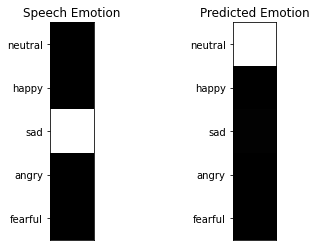

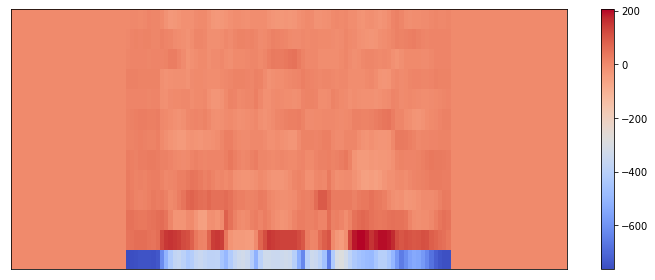

1/1 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000
[[1.2726598e-06 9.9999845e-01 6.1102984e-10 2.1428917e-07 2.6009220e-08]]


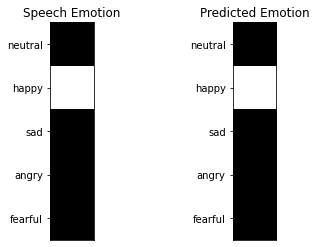

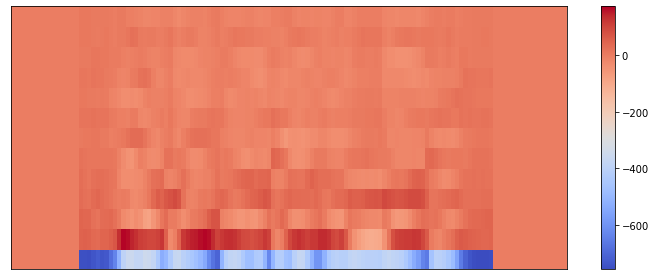

1/1 [==============================] - 0s 15ms/step - loss: 0.0033 - accuracy: 1.0000
[[9.9998164e-01 1.6421704e-10 1.6770344e-05 5.7568560e-08 1.5568502e-06]]


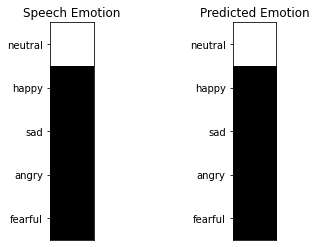

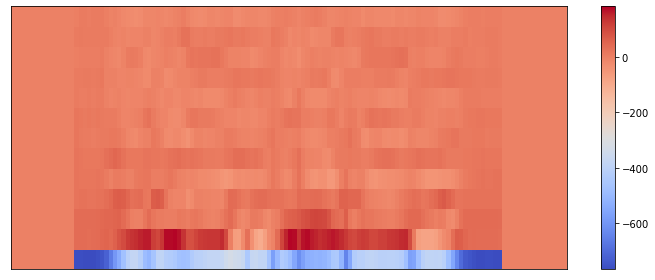

1/1 [==============================] - 0s 15ms/step - loss: 0.5817 - accuracy: 1.0000
[[5.7388574e-01 4.2610273e-01 4.3740599e-07 5.8053824e-06 5.3621320e-06]]


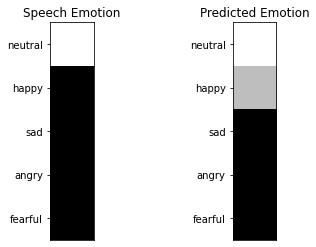

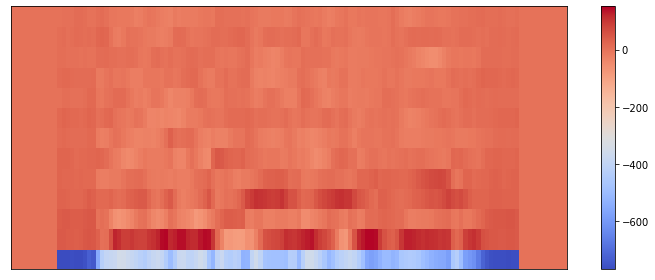

1/1 [==============================] - 0s 15ms/step - loss: 0.0084 - accuracy: 1.0000
[[1.2163230e-06 1.3695548e-04 7.6478563e-07 9.9961603e-01 2.4502963e-04]]


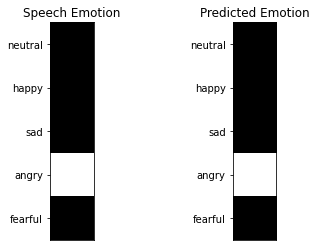

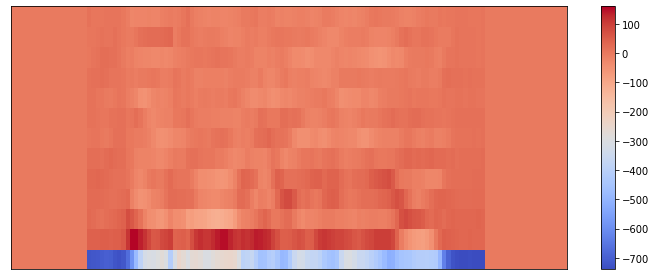

1/1 [==============================] - 0s 15ms/step - loss: 0.0274 - accuracy: 1.0000
[[2.0548885e-04 1.8088670e-03 1.4976995e-07 2.8151931e-07 9.9798524e-01]]


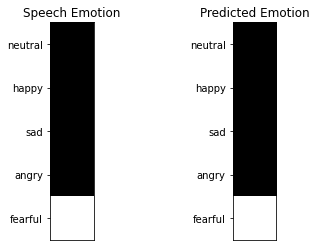

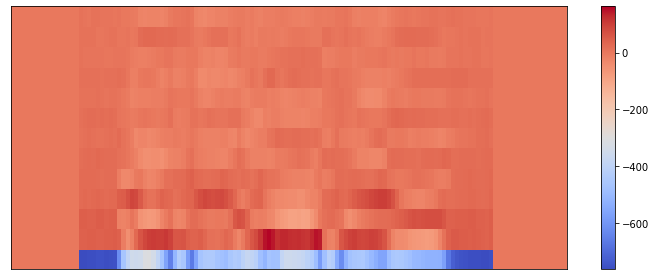

1/1 [==============================] - 0s 15ms/step - loss: 0.1162 - accuracy: 1.0000
[[1.2262836e-02 5.6560584e-08 9.8773396e-01 2.0446662e-09 3.1333734e-06]]


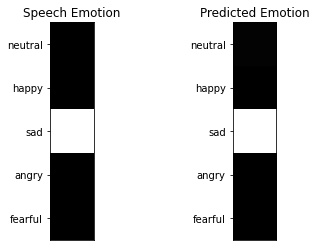

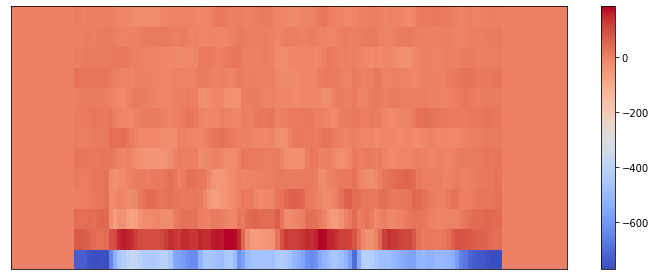

1/1 [==============================] - 0s 23ms/step - loss: 0.6595 - accuracy: 0.0000e+00
[[0.21728669 0.00468886 0.47279757 0.29549587 0.00973104]]


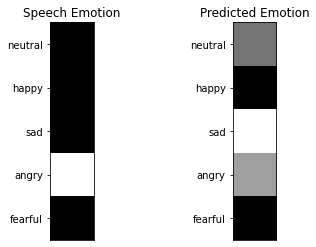

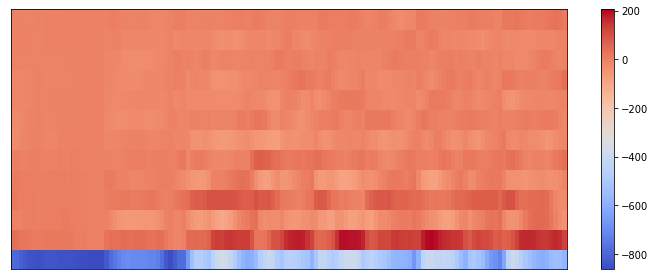

1/1 [==============================] - 0s 14ms/step - loss: 0.3540 - accuracy: 1.0000
[[1.2845229e-02 8.5857237e-06 8.2361948e-01 3.9253994e-03 1.5960135e-01]]


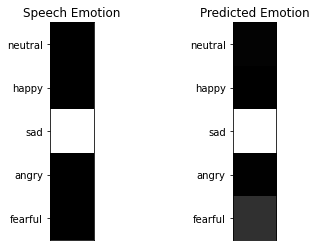

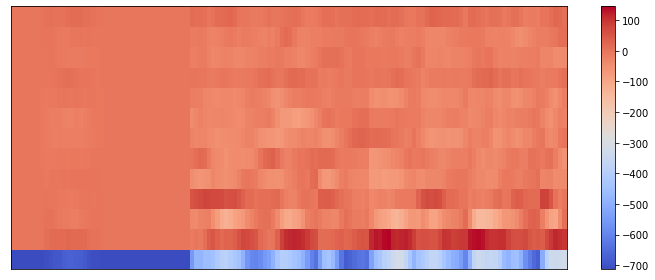

1/1 [==============================] - 0s 15ms/step - loss: 0.0548 - accuracy: 1.0000
[[4.4509344e-04 3.3280556e-10 9.9955446e-01 1.2092143e-07 3.9039506e-07]]


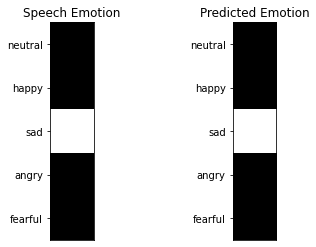

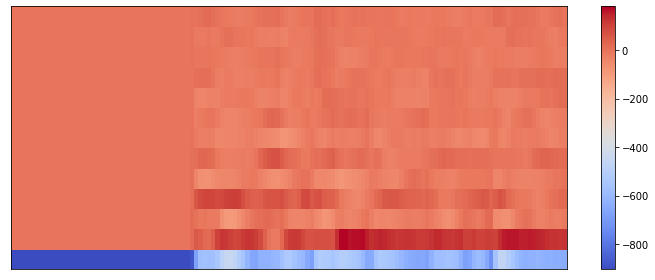

1/1 [==============================] - 0s 15ms/step - loss: 0.1107 - accuracy: 1.0000
[[3.7753958e-02 1.5501761e-02 1.8363993e-05 7.9295387e-06 9.4671804e-01]]


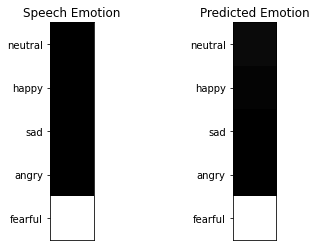

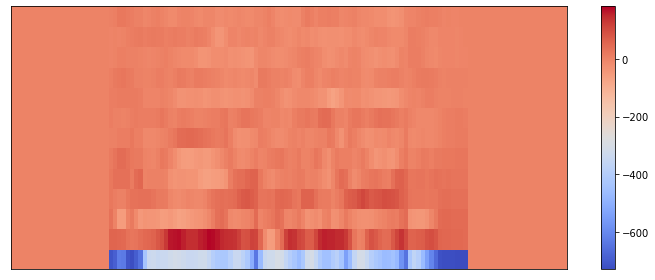

1/1 [==============================] - 0s 15ms/step - loss: 0.0041 - accuracy: 1.0000
[[2.98017625e-07 9.99891520e-01 1.30941045e-08 1.05872568e-04
  2.22911603e-06]]


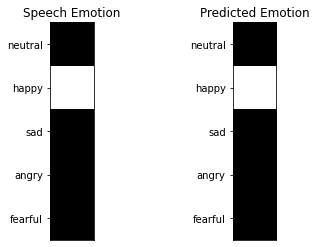

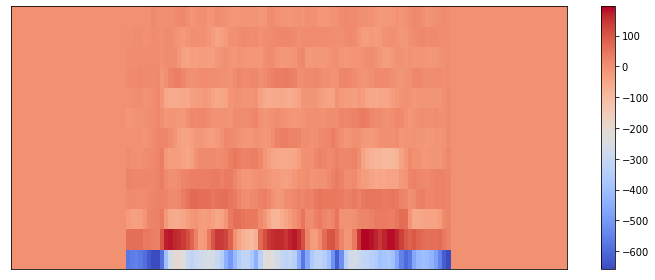

In [19]:

for example in range(len(X_train[50:100])):

    mfccs_sample = X_test[example]
    out_sample = Y_test[example]

    Model.evaluate(mfccs_sample.reshape((-1, 13, 130, 1)), out_sample.reshape((-1, 5, 1)))
    predicted = Model.predict(X_test[example].reshape((-1, 13, 130, 1)))
    print(predicted)

    fig, (ax2, ax3) = plt.subplots(1, 2)

    emotions = ["", 'neutral', 'happy', 'sad', 'angry', 'fearful']

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs_sample.reshape(13, 130))
    plt.colorbar()
    plt.tight_layout()
    # ax1.imshow((mfccs_sample.reshape(13, 130)), cmap="gray")
    # ax1.set_title("Speech MFCC")

    ax2.imshow((out_sample.reshape(5, 1)), cmap="gray")
    ax2.tick_params(axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False)
    ax2.set_yticklabels(emotions)
    ax2.set_title("Speech Emotion")

    ax3.imshow((predicted.reshape(5, 1)), cmap="gray")
    ax3.tick_params(axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False)
    ax3.set_yticklabels(emotions)
    ax3.set_title("Predicted Emotion")

    plt.show()

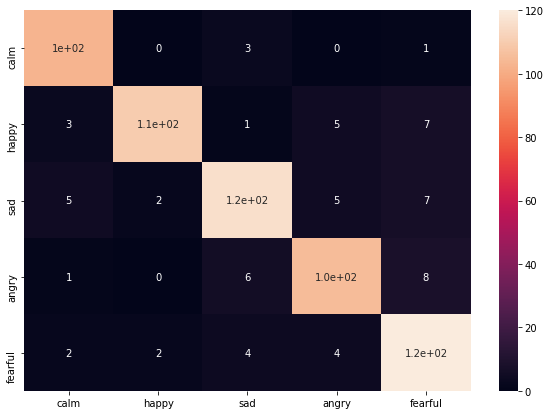

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = np.argmax(Model.predict(X_test), axis=1)
confusion =  confusion_matrix(Y_test.argmax(axis=1), Y_pred)

df_confusion = pd.DataFrame(confusion, index = ['calm', 'happy', 'sad', 'angry', 'fearful'],
                     columns = ['calm', 'happy', 'sad', 'angry', 'fearful'])
plt.figure(figsize = (10,7))
sn.heatmap(df_confusion, annot=True)

In [21]:
tf.keras.models.save_model(Model, '/content/drive/MyDrive/model_speech_jl_rav')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_speech_jl_rav/assets
